# Transfer Learning with PyTorch

#### In pratice, very few people train an entire Convolutional Network from scratch(with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest

## Two major transfer learning scenarios
- Finetuning the convnet: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
- ConvNet as fixed feature extractor: Here,we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [1]:
# Licence: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function,division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets,models,transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()     # interactive mode

## Load Data
Train a model to classify ants and bees. We have a small dataset which contains 120 training images each for ants and bees and 75 validation images for each class.Usually this is a very small dataset to generalize upon if trained from scratch. But with transfer learning, we should generalize well.

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) 
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),
                                        data_transforms[x])
                 for x in ['train','val']}

dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,
                                            shuffle=True,num_workers=4)
              for x in ['train','val']}
dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visualize a few images

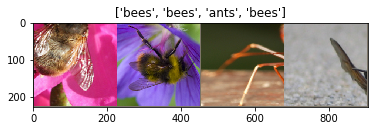

In [19]:
def imshow(inp,title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)          # pause a bit so that plots are updated

# Get a batch of training data
inputs,classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out,title=[class_names[x] for x in classes])

## Train the model
- Scheduling the learning rate
- Saving the best model

In [36]:
def train_model(model,criterion,optimizer,scheduler,num_epochs=25):
    since = time.time()
    
    best_modes_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train()        # Set model to training mode
            else:
                model.eval()        # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase,epoch_loss,epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

In [39]:
def visualize_model(model,num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i,(inputs,labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = inputs.to(device)
            
            outputs = model(inputs)
            _,preds = torch.max(outputs,1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2,2,images_so_far)
                ax.axis('off')
                ax.set_title('predicted:{}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


### Finetuning the convnet

In [34]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001,momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Administrator/.torch\models\resnet18-5c106cde.pth
100.0%


In [37]:
model_ft = train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5908 Acc: 0.7049
val Loss: 0.2981 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.4641 Acc: 0.8115
val Loss: 0.6321 Acc: 0.7908

Epoch 2/24
----------
train Loss: 0.5778 Acc: 0.7541
val Loss: 0.4407 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.4791 Acc: 0.7992
val Loss: 0.5193 Acc: 0.7778

Epoch 4/24
----------
train Loss: 0.5608 Acc: 0.7787
val Loss: 0.5308 Acc: 0.8105

Epoch 5/24
----------
train Loss: 0.4991 Acc: 0.8156
val Loss: 0.4220 Acc: 0.8235

Epoch 6/24
----------
train Loss: 0.3534 Acc: 0.8320
val Loss: 0.3185 Acc: 0.8627

Epoch 7/24
----------
train Loss: 0.2832 Acc: 0.8730
val Loss: 0.2775 Acc: 0.8693

Epoch 8/24
----------
train Loss: 0.3950 Acc: 0.8074
val Loss: 0.2964 Acc: 0.8758

Epoch 9/24
----------
train Loss: 0.3864 Acc: 0.8484
val Loss: 0.2506 Acc: 0.8889

Epoch 10/24
----------
train Loss: 0.3166 Acc: 0.8443
val Loss: 0.2827 Acc: 0.8627

Epoch 11/24
----------
train Loss: 0.3404 Acc: 0.8402
val Loss: 0.2487 Acc: 0.8889

Ep

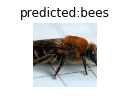

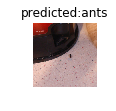

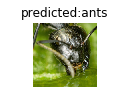

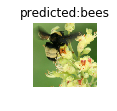

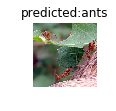

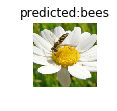

In [40]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor
Freeze all the network except the final layer. We need to set <font color=red>requires_grad==False</font> to freeze the parameters so that the gradients are not computed in <font color=red>backward()</font>

In [48]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(),lr=0.001,momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epoexp_lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv,step_size=7,gamma=0.1)

In [50]:
model_conv = train_model(model_conv,criterion,optimizer_conv,exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5558 Acc: 0.7049
val Loss: 0.2489 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.4137 Acc: 0.8197
val Loss: 0.2438 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.4466 Acc: 0.8156
val Loss: 0.1936 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.5704 Acc: 0.7541
val Loss: 0.1988 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4590 Acc: 0.7992
val Loss: 0.1692 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.5477 Acc: 0.7705
val Loss: 0.4126 Acc: 0.8431

Epoch 6/24
----------
train Loss: 0.5103 Acc: 0.7869
val Loss: 0.1867 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.3712 Acc: 0.8320
val Loss: 0.1951 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3969 Acc: 0.7992
val Loss: 0.1773 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3626 Acc: 0.8402
val Loss: 0.1715 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.4098 Acc: 0.8156
val Loss: 0.2142 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3637 Acc: 0.8320
val Loss: 0.1959 Acc: 0.9412

Ep

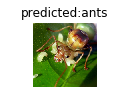

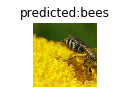

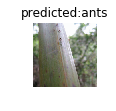

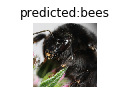

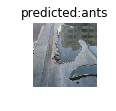

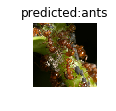

In [51]:
visualize_model(model_conv)